# Multiclass Support Vector Machine exercise

本练习中你将：
1. 实现一个用于SVM的完全向量化的**损失函数**
2. 实现损失函数的**解析梯度analytic gradient**的完全向量化表达式
3. 使用数值梯度**检查解析梯度的实现**
4. 使用**SGD随机梯度下降算法**来优化损失函数
5. **可视化**最终学习的权重


In [1]:
# Run some setup code for this notebook.

import random
import numpy as np
from utils.datasets_util import load_cifar10
import matplotlib.pyplot as plt


# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

这部分和`Q1_knn.ipynb`文件是一样的, 实现的功能和`code/utils/datasets_util.py`中的`get_CIFAR10_data`差不多

In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = '../../datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_cifar10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


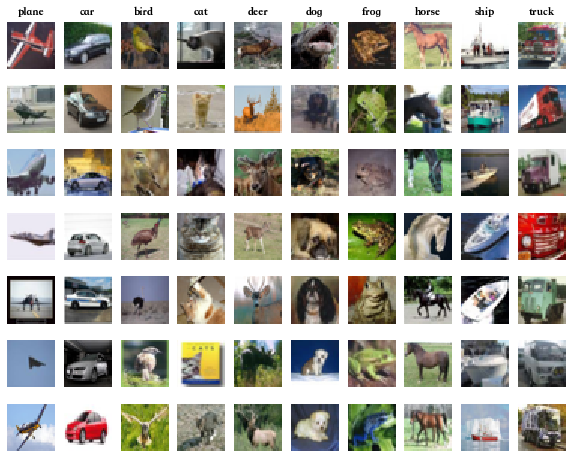

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx])
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

X_val = X_train[num_training:num_training + num_validation].astype(float)
y_val = y_train[num_training:num_training + num_validation]

X_train = X_train[:num_training].astype(float)
y_train = y_train[:num_training]

X_test = X_test[:num_test].astype(float)
y_test = y_test[:num_test]

# We will also make a development set, which is a small subset of
# the training set.
# 从训练集中划分出一个小的训练集，用来快速验证学习率和检查代码
# https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask].astype(float)
y_dev = y_train[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [5]:
# Preprocessing: reshape the image data into rows
# 把image转换成行向量，即(49000, 32, 32, 3)→(49000,32*32*3), 作为后续SVM的输入
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


(3072,) [130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


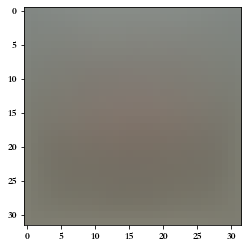

In [6]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
# 1. 计算图像的均值（不是通道均值）
mean_image = np.mean(X_train, axis=0)
print(mean_image.shape, mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

所以图像的均值就是灰不溜秋的一团（所有颜料混在一起就是黑的。。。）

In [7]:
# second: subtract the mean image from train and test data
# 2. 从数据集中减去图像的均值
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [8]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
# 3. 把bias的维度以全1向量的形式添加到数据的后面（bias的小技巧），这样SVM只需要优化权重W即可
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


+ <https://scikit-learn.org/stable/modules/svm.html>
+ <https://scikit-learn.org/stable/modules/kernel_approximation.html#kernel-approximation>

## SVM Classifier
+ 这部分代码要在**utils/classifiers/linear_svm.py**中实现
+ 补全函数使用循环评估多类SVM损失函数（multiclass SVM loss function）的`compute_loss_naive`

In [15]:
# Evaluate the naive implementation of the loss we provided for you:
from utils.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 9.006638


In [12]:
grad.shape,grad[:2:10]

((3073, 10),
 array([[-12.59352731,  -2.05421918,  28.77353175,   6.3488911 ,
          13.22006849,  41.26705775,  11.77234314,   1.95947486,
         -51.68621135, -27.15998845]]))

+ 现在上述函数返回的`grad`梯度值目前全都是0，在函数`svm_loss_naive`中对SVM损失函数求导并实现梯度计算。你会发现把这些代码插入到现有函数中会很有用。
+ 为了检查是否正确实现了求解梯度，可以对损失函数的梯度进行数值估计并比较数值估计和你刚刚实现的梯度结果，我们在下面为你提供了这些代码

In [20]:
# 实现好了求梯度的代码后，使用下面的代码重新计算梯度，并使用我们提供的代码进行检查

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# 随机选择几个维度进行梯度的数值计算，将其与你实现的解析梯度结果进行比较，两种计算结果在所有维度上应该都是基本相等的
from utils.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

print("with regularization")
# 再使用有正则项的结果检查一遍梯度
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: -1.575552 analytic: -1.575552, relative error: 7.456340e-11
numerical: 9.560265 analytic: 9.560265, relative error: 2.194688e-11
numerical: 32.666307 analytic: 32.666307, relative error: 2.727644e-12
numerical: 20.992956 analytic: 20.992956, relative error: 1.677105e-12
numerical: -0.642574 analytic: -0.642574, relative error: 3.972628e-10
numerical: -0.708459 analytic: -0.708459, relative error: 1.713012e-10
numerical: 32.019328 analytic: 32.019328, relative error: 1.576364e-11
numerical: 31.310731 analytic: 31.310731, relative error: 8.206169e-12
numerical: -18.437514 analytic: -18.437514, relative error: 2.296472e-12
numerical: 15.254207 analytic: 15.254207, relative error: 7.697248e-12
with regularization
numerical: 18.941325 analytic: 18.941325, relative error: 1.344554e-11
numerical: 24.726517 analytic: 24.726517, relative error: 3.012976e-13
numerical: 8.487452 analytic: 8.487452, relative error: 3.222178e-11
numerical: 33.492827 analytic: 33.492827, relative error: 5

### 问题1:

+ 有时候梯度检查会不完全匹配，造成这种差异的原因是什么？
+ 造成这一差异的原因会很影响程序的正确结果吗？
+ 一个简单的梯度检查失败的例子是什么？（提示：SVM的损失函数严格来说不可微分，strictly speaking differentiable）

**你的回答:** 
+ 数值解是近似解，当位于SVM损失函数不可导的点时，两个结果会不一样
+ 由于SVM loss function中存在max，简化表示：$f(x)=max(x,0)$
+ 对于数值求解来说：
    + $x=0,f(x)=0$
    + $x=0.001,f(x)=0.001$, $x=-0.001,f(x)=0$
    + $dx=\frac{f(x+\delta x)-f(x)}{\delta x}$
    + 右导数：$\lim_{x \to 0^+}\frac{f(0.001)-f(0)}{0.001}=1$
    + 左导数：$\lim_{x \to 0^-}\frac{f(-0.001)-f(0)}{-0.001}=0$

<img src="../../images/singleSideGradient.jpg" width="50%" />

In [42]:
# fail calculate gradient
# X:(N,D) N=1, D=3
# W:(D,C) D=3, C=3
# Y:(N, ) 
X_example = np.array([[1,1,1]],dtype=float) 
Y_example=np.array([2])
W_example=np.array([[0,0,1],[0,0,1],[0,2,1]],dtype=float)
loss, grad = svm_loss_naive(W_example, X_example, Y_example, 0.0)
f = lambda w: svm_loss_naive(w, X_example, Y_example, 0.0)[0]
grad_numerical = grad_check_sparse(f, W_example, grad)

numerical: 0.000000 analytic: 0.000000, relative error: nan
numerical: 0.000000 analytic: 0.000000, relative error: nan
numerical: -0.500000 analytic: 0.000000, relative error: 1.000000e+00
numerical: -0.500000 analytic: 0.000000, relative error: 1.000000e+00
numerical: 0.000000 analytic: 0.000000, relative error: nan
numerical: -0.500000 analytic: 0.000000, relative error: 1.000000e+00
numerical: -0.500000 analytic: 0.000000, relative error: 1.000000e+00
numerical: 0.000000 analytic: 0.000000, relative error: nan
numerical: 0.000000 analytic: 0.000000, relative error: nan
numerical: -0.500000 analytic: 0.000000, relative error: 1.000000e+00


/Users/huangshan/Documents/DailyStudy/cs231n/code/Assignment1/utils/gradient_check.py:132: RuntimeWarning: invalid value encountered in double_scalars


In [ ]:
# 接下来实现svm_loss_vectorized,向量化求解loss的函数，对比和使用循环计算梯度所花费的时间
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from utils.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

In [ ]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [ ]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

In [ ]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [ ]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

In [ ]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
learning_rates = [1e-7, 5e-5]
regularization_strengths = [2.5e4, 5e4]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
pass
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

In [ ]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [ ]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

In [ ]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

### Inline question 2:
Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

**Your answer:** *fill this in*

# 测试代码

In [43]:
X_example = np.array([[1,1,1],[2,2,2]],dtype=float) 
W_example = np.array([[0.5,0.5],[0.2,0.2],[0.1,0.1]],dtype=float) 
X_example.dot(W_example)

array([[0.8, 0.8],
       [1.6, 1.6]])

# 求导公式推导

In [19]:
X_dev[1,:20],X_dev[1,:20].T

(array([-34.64189796,  21.01826531,  94.52608163, -40.05569388,
         15.65195918,  93.24597959, -55.96055102,   0.85671429,
         82.52363265, -45.48467347,  12.41457143,  89.21706122,
        -49.094     ,   9.85991837,  84.823     , -54.76759184,
          3.22232653,  81.29397959, -52.29373469,   3.78755102]),
 array([-34.64189796,  21.01826531,  94.52608163, -40.05569388,
         15.65195918,  93.24597959, -55.96055102,   0.85671429,
         82.52363265, -45.48467347,  12.41457143,  89.21706122,
        -49.094     ,   9.85991837,  84.823     , -54.76759184,
          3.22232653,  81.29397959, -52.29373469,   3.78755102]))

![img](../../images/derive.jpg)

<img src="../../images/svm_loss.jpg" width="50%">
<img src="../../images/svm_loss2.jpg" width="30%">'

默认假设x的维度是(49000,3072),则对于10分类
$$y=wx+b$$
+ $x:49000\times 3072, w:3072\times 10, b:1\times 10$(每个样本的xw输出是10，每个样本的10个输出上分别加上b的10个数字，广播), 
+ $y:49000\times 10$

为了只优化w，即把b合并到w中，可以
+ 在每个样本后面添加一个1,即3072+1
+ 则对于X_train来说，就是添加一个全1的列
+ 则变成了 $y=wx$
+ $X:49000\times 3073, W:3073\times 10,Y:49000\times 10$,和上面的是等价的

关于求导，完整的公式应该是：
$$
\frac{\partial {L}}{\partial {f}}\frac{\partial {f}}{\partial {W}}
$$
+ 注意，公式里写了$j\neq y_i$
+ 如果$j==y_i$或者$s_{y_i} \ge s_j+1$，则对应的loss为0，同时这种情况下，$L=max(0,1)$，则此时导数=0
+ 否则, $\frac{\partial {L}}{\partial {f}}=1$, $\frac{\partial {f}}{\partial {W}}$的情况则比较复杂，
    + 其实是$f(x_i;W)j-f(x_i;W)y_i+1$对不同的$w_i$求导, 假设真值$y_i$=3, 则$j\in(0,1,2,4,5,6,7,8,9)$
    + 如果是对于非$y_i$对应之外的$w_j$求导，例如，对$w_0$求导，则$\frac{\partial {L}}{\partial {w_0}}=x_i$
    + 如果是对于$y_i$求导（假设真值$y_i$=3），即对$w_3$求导，则$\frac{\partial {L}}{\partial {w_3}}=-x_i$
+ `margin = scores[j] - correct_class_score + 1`

参考：
+ <https://stackoverflow.com/questions/36020583/compute-the-gradient-of-the-svm-loss-function>
+ <https://stats.stackexchange.com/questions/155088/gradient-for-hinge-loss-multiclass>
+ <https://cs231n.github.io/optimization-1/>

感知机结构绘制：
+ <https://en.wikipedia.org/wiki/Perceptron>
+ <https://towardsdatascience.com/perceptron-learning-algorithm-d5db0deab975>
+ <https://www.javatpoint.com/single-layer-perceptron-in-tensorflow>
+ <https://epynn.net/Dense.html>
+ <https://stackoverflow.com/questions/53851652/not-fully-connected-layer-in-tensorflow>
+ <https://sebastianraschka.com/faq/docs/fc-to-conv.html>